In [1]:
import time
import numpy as np
import pandas as pd
from dateutil.parser import parse
from datetime import date, timedelta
from sklearn.preprocessing import LabelEncoder

data_path = '../data/'

In [2]:
# 加载数据
air_reserve = pd.read_csv(data_path + 'air_reserve.csv').rename(columns={'air_store_id':'store_id'})
hpg_reserve = pd.read_csv(data_path + 'hpg_reserve.csv').rename(columns={'hpg_store_id':'store_id'})
air_store = pd.read_csv(data_path + 'air_store_info.csv').rename(columns={'air_store_id':'store_id'})
hpg_store = pd.read_csv(data_path + 'hpg_store_info.csv').rename(columns={'hpg_store_id':'store_id'})
air_visit = pd.read_csv(data_path + 'air_visit_data.csv').rename(columns={'air_store_id':'store_id'})
store_id_map = pd.read_csv(data_path + 'store_id_relation.csv').set_index('hpg_store_id',drop=False)
date_info = pd.read_csv(data_path + 'date_info.csv').rename(columns={'calendar_date': 'visit_date'}).drop('day_of_week',axis=1)
submission = pd.read_csv(data_path + 'sample_submission.csv')

In [7]:
# 在submission中增加visit_date和store_id
submission['visit_date'] = submission['id'].str[-10:]
submission['store_id'] = submission['id'].str[:-11]

# 在air预定数据中增加visit_date, reserve_date和dow
air_reserve['visit_date'] = air_reserve['visit_datetime'].str[:10]
air_reserve['reserve_date'] = air_reserve['reserve_datetime'].str[:10]
air_reserve['dow'] = pd.to_datetime(air_reserve['visit_date']).dt.dayofweek

# 在hpg预定信息中增加visit_date, reserve_date和dow
hpg_reserve['visit_date'] = hpg_reserve['visit_datetime'].str[:10]
hpg_reserve['reserve_date'] = hpg_reserve['reserve_datetime'].str[:10]
hpg_reserve['dow'] = pd.to_datetime(hpg_reserve['visit_date']).dt.dayofweek

# 在air_visit数据中增加id列
air_visit['id'] = air_visit['store_id'] + '_' + air_visit['visit_date']

# 在hpg预定和商家信息中匹配air_store_id, 将商家信息中的genre和area列改名
hpg_reserve['store_id'] = hpg_reserve['store_id'].map(store_id_map['air_store_id']).fillna(hpg_reserve['store_id'])
hpg_store['store_id'] = hpg_store['store_id'].map(store_id_map['air_store_id']).fillna(hpg_store['store_id'])
hpg_store.rename(columns={'hpg_genre_name':'air_genre_name','hpg_area_name':'air_area_name'},inplace=True)


data = pd.concat([air_visit, submission]).copy()
data['dow'] = pd.to_datetime(data['visit_date']).dt.dayofweek

# 增加holiday_flg2标记假期是否是周末
date_info['holiday_flg2'] = pd.to_datetime(date_info['visit_date']).dt.dayofweek
date_info['holiday_flg2'] = ((date_info['holiday_flg2']> 4) | (date_info['holiday_flg'] == 1)).astype(int)

# 增加一级地区
air_store['air_area_name0'] = air_store['air_area_name'].apply(lambda x: x.split(' ')[0])

# 对air_genre_name和air_area_name0
lbl = LabelEncoder()
air_store['air_genre_name'] = lbl.fit_transform(air_store['air_genre_name'])
air_store['air_area_name0'] = lbl.fit_transform(air_store['air_area_name0'])

# 在data上匹配商家信息和假期信息
data['visitors'] = np.log1p(data['visitors'])
data = data.merge(air_store,on='store_id',how='left')
data = data.merge(date_info[['visit_date','holiday_flg','holiday_flg2']], on=['visit_date'],how='left')

## 辅助函数

In [9]:
###################################### function #########################################
def concat(L):
    result = None
    for l in L:
        if result is None:
            result = l
        else:
            try:
                result[l.columns.tolist()] = l
            except:
                print(l.head())
    return result

def left_merge(data1, data2, on):
    '''
        返回data1和data2左连接的结果
    '''
    if type(on) != list:
        on = [on]
    if (set(on) & set(data2.columns)) != set(on):
        data2_temp = data2.reset_index()
    else:
        data2_temp = data2.copy()
    columns = [f for f in data2.columns if f not in on]
    result = data1.merge(data2_temp, on=on, how='left')
    result = result[columns]
    return result


def diff_of_days(day1, day2):
    '''
        计算两个日期字符串的时间间隔
    '''
    days = (parse(day1[:10]) - parse(day2[:10])).days
    return days

def date_add_days(start_date, days):
    '''
        在start_date上加上days
    '''
    end_date = parse(start_date[:10]) + timedelta(days=days)
    end_date = end_date.strftime('%Y-%m-%d')
    return end_date


def get_label(end_date, n_day):
    label_end_date = date_add_days(end_date, n_day)
    label = data[(data['visit_date'] < label_end_date) & (data['visit_date'] >= end_date)].copy()
    label['end_date'] = end_date
    label['diff_of_day'] = label['visit_date'].apply(lambda x: diff_of_days(x,end_date))
    label['month'] = label['visit_date'].str[5:7].astype(int)
    label['year'] = label['visit_date'].str[:4].astype(int)
    for i in [3, 2, 1, -1]:
        date_info_temp = date_info.copy()
        date_info_temp['visit_date'] = date_info_temp['visit_date'].apply(lambda x: date_add_days(x, i))
        date_info_temp.rename(columns={'holiday_flg':'ahead_holiday_{}'.format(i),'holiday_flg2':'ahead_holiday2_{}'.format(i)},inplace=True)
        label = label.merge(date_info_temp, on=['visit_date'],how='left')
    label = label.reset_index(drop=True)
    return label


In [66]:
start_date = '2017-03-12'
min_date = data['visit_date'].min()
max_date = air_visit['visit_date'].max()

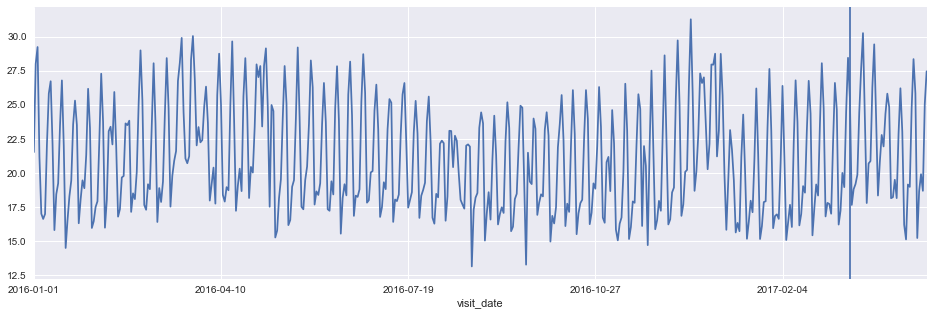

In [65]:
fig, ax = plt.subplots(figsize=(16, 5))
air_visit.groupby('visit_date')['visitors'].mean().plot(ax=ax)
ax.axvline(diff_of_days(start_date, min_date))

In [67]:
diff_of_days(start_date, max_date)

-41

## 商家特征

In [32]:
def get_store_visitor_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    result = data_temp.groupby(['store_id'], as_index=False)['visitors'].agg({'store_min{}'.format(n_day): 'min',
                                                                             'store_mean{}'.format(n_day): 'mean',
                                                                             'store_median{}'.format(n_day): 'median',
                                                                             'store_max{}'.format(n_day): 'max',
                                                                             'store_count{}'.format(n_day): 'count',
                                                                             'store_std{}'.format(n_day): 'std',
                                                                             'store_skew{}'.format(n_day): 'skew'})
    result = left_merge(label, result, on=['store_id']).fillna(0)
    return result


def get_store_exp_visitor_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    data_temp['visit_date'] = data_temp['visit_date'].apply(lambda x: diff_of_days(key[0],x))
    data_temp['weight'] = data_temp['visit_date'].apply(lambda x: 0.985**x)
    data_temp['visitors'] = data_temp['visitors'] * data_temp['weight']
    result1 = data_temp.groupby(['store_id'], as_index=False)['visitors'].agg({'store_exp_mean{}'.format(n_day): 'sum'})
    result2 = data_temp.groupby(['store_id'], as_index=False)['weight'].agg({'store_exp_weight_sum{}'.format(n_day): 'sum'})
    result = result1.merge(result2, on=['store_id'], how='left')
    result['store_exp_mean{}'.format(n_day)] = result['store_exp_mean{}'.format(n_day)]/result['store_exp_weight_sum{}'.format(n_day)]
    result = left_merge(label, result, on=['store_id']).fillna(0)
    return result



def get_store_week_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    result = data_temp.groupby(['store_id', 'dow'], as_index=False)['visitors'].agg({'store_dow_min{}'.format(n_day): 'min',
                                                                                     'store_dow_mean{}'.format(n_day): 'mean',
                                                                                     'store_dow_median{}'.format(n_day): 'median',
                                                                                     'store_dow_max{}'.format(n_day): 'max',
                                                                                     'store_dow_count{}'.format(n_day): 'count',
                                                                                     'store_dow_std{}'.format(n_day): 'std',
                                                                                     'store_dow_skew{}'.format(n_day): 'skew'})
    result = left_merge(label, result, on=['store_id', 'dow']).fillna(0)
    return result


def get_store_week_diff_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    result = data_temp.set_index(['store_id','visit_date'])['visitors'].unstack()
    result = result.diff(axis=1).iloc[:,1:]
    c = result.columns
    result['store_diff_mean'] = np.abs(result[c]).mean(axis=1)
    result['store_diff_std'] = result[c].std(axis=1)
    result['store_diff_max'] = result[c].max(axis=1)
    result['store_diff_min'] = result[c].min(axis=1)
    result = left_merge(label, result[['store_diff_mean', 'store_diff_std', 'store_diff_max', 'store_diff_min']],on=['store_id']).fillna(0)
    return result


def get_store_all_week_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    result_temp = data_temp.groupby(['store_id', 'dow'],as_index=False)['visitors'].agg({'store_dow_mean{}'.format(n_day): 'mean',
                                                                     'store_dow_median{}'.format(n_day): 'median',
                                                                     'store_dow_sum{}'.format(n_day): 'max',
                                                                     'store_dow_count{}'.format(n_day): 'count'})
    result = pd.DataFrame()
    for i in range(7):
        result_sub = result_temp[result_temp['dow']==i].copy()
        result_sub = result_sub.set_index('store_id')
        result_sub = result_sub.add_prefix(str(i))
        result_sub = left_merge(label, result_sub, on=['store_id']).fillna(0)
        result = pd.concat([result,result_sub],axis=1)
    return result



def get_store_week_exp_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    data_temp['visit_date'] = data_temp['visit_date'].apply(lambda x: diff_of_days(key[0],x))
    data_temp['visitors2'] = data_temp['visitors']
    result = None
    for i in [0.9,0.95,0.97,0.98,0.985,0.99,0.999,0.9999]:
        data_temp['weight'] = data_temp['visit_date'].apply(lambda x: i**x)
        data_temp['visitors1'] = data_temp['visitors'] * data_temp['weight']
        data_temp['visitors2'] = data_temp['visitors2'] * data_temp['weight']
        result1 = data_temp.groupby(['store_id', 'dow'], as_index=False)['visitors1'].agg({'store_dow_exp_mean{}_{}'.format(n_day,i): 'sum'})
        result3 = data_temp.groupby(['store_id', 'dow'], as_index=False)['visitors2'].agg({'store_dow_exp_mean2{}_{}'.format(n_day, i): 'sum'})
        result2 = data_temp.groupby(['store_id', 'dow'], as_index=False)['weight'].agg({'store_dow_exp_weight_sum{}_{}'.format(n_day,i): 'sum'})
        result_temp = result1.merge(result2, on=['store_id', 'dow'], how='left')
        result_temp = result_temp.merge(result3, on=['store_id', 'dow'], how='left')
        result_temp['store_dow_exp_mean{}_{}'.format(n_day,i)] = result_temp['store_dow_exp_mean{}_{}'.format(n_day,i)]/result_temp['store_dow_exp_weight_sum{}_{}'.format(n_day,i)]
        result_temp['store_dow_exp_mean2{}_{}'.format(n_day, i)] = result_temp[ 'store_dow_exp_mean2{}_{}'.format(n_day, i)]/result_temp['store_dow_exp_weight_sum{}_{}'.format(n_day, i)]
        if result is None:
            result = result_temp
        else:
            result = result.merge(result_temp,on=['store_id','dow'],how='left')
    result = left_merge(label, result, on=['store_id', 'dow']).fillna(0)
    return result


def get_store_holiday_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    result1 = data_temp.groupby(['store_id', 'holiday_flg'], as_index=False)['visitors'].agg(
        {'store_holiday_min{}'.format(n_day): 'min',
         'store_holiday_mean{}'.format(n_day): 'mean',
         'store_holiday_median{}'.format(n_day): 'median',
         'store_holiday_max{}'.format(n_day): 'max',
         'store_holiday_count{}'.format(n_day): 'count',
         'store_holiday_std{}'.format(n_day): 'std',
         'store_holiday_skew{}'.format(n_day): 'skew'})
    result1 = left_merge(label, result1, on=['store_id', 'holiday_flg']).fillna(0)
    result2 = data_temp.groupby(['store_id', 'holiday_flg2'], as_index=False)['visitors'].agg(
        {'store_holiday2_min{}'.format(n_day): 'min',
         'store_holiday2_mean{}'.format(n_day): 'mean',
         'store_holiday2_median{}'.format(n_day): 'median',
         'store_holiday2_max{}'.format(n_day): 'max',
         'store_holiday2_count{}'.format(n_day): 'count',
         'store_holiday2_std{}'.format(n_day): 'std',
         'store_holiday2_skew{}'.format(n_day): 'skew'})
    result2 = left_merge(label, result2, on=['store_id', 'holiday_flg2']).fillna(0)
    result = pd.concat([result1, result2], axis=1)
    return result


In [33]:
def get_genre_visitor_feat(label, key, n_day):
    start_date = date_add_days(key[0],-n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    result = data_temp.groupby(['air_genre_name'], as_index=False)['visitors'].agg({'genre_min{}'.format(n_day): 'min',
                                                                             'genre_mean{}'.format(n_day): 'mean',
                                                                             'genre_median{}'.format(n_day): 'median',
                                                                             'genre_max{}'.format(n_day): 'max',
                                                                             'genre_count{}'.format(n_day): 'count',
                                                                             'genre_std{}'.format(n_day): 'std',
                                                                             'genre_skew{}'.format(n_day): 'skew'})
    result = left_merge(label, result, on=['air_genre_name']).fillna(0)
    return result


def get_genre_exp_visitor_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    data_temp['visit_date'] = data_temp['visit_date'].apply(lambda x: diff_of_days(key[0],x))
    data_temp['weight'] = data_temp['visit_date'].apply(lambda x: 0.985**x)
    data_temp['visitors'] = data_temp['visitors'] * data_temp['weight']
    result1 = data_temp.groupby(['air_genre_name'], as_index=False)['visitors'].agg({'genre_exp_mean{}'.format(n_day): 'sum'})
    result2 = data_temp.groupby(['air_genre_name'], as_index=False)['weight'].agg({'genre_exp_weight_sum{}'.format(n_day): 'sum'})
    result = result1.merge(result2, on=['air_genre_name'], how='left')
    result['genre_exp_mean{}'.format(n_day)] = result['genre_exp_mean{}'.format(n_day)]/result['genre_exp_weight_sum{}'.format(n_day)]
    result = left_merge(label, result, on=['air_genre_name']).fillna(0)
    return result


def get_genre_week_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    result = data_temp.groupby(['air_genre_name', 'dow'], as_index=False)['visitors'].agg({'genre_dow_min{}'.format(n_day): 'min',
                                                                                         'genre_dow_mean{}'.format(n_day): 'mean',
                                                                                         'genre_dow_median{}'.format(n_day): 'median',
                                                                                         'genre_dow_max{}'.format(n_day): 'max',
                                                                                         'genre_dow_count{}'.format(n_day): 'count',
                                                                                         'genre_dow_std{}'.format(n_day): 'std',
                                                                                         'genre_dow_skew{}'.format(n_day): 'skew'})
    result = left_merge(label, result, on=['air_genre_name', 'dow']).fillna(0)
    return result


def get_genre_week_exp_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    data_temp['visit_date'] = data_temp['visit_date'].apply(lambda x: diff_of_days(key[0],x))
    data_temp['weight'] = data_temp['visit_date'].apply(lambda x: 0.985**x)
    data_temp['visitors'] = data_temp['visitors'] * data_temp['weight']
    result1 = data_temp.groupby(['air_genre_name', 'dow'], as_index=False)['visitors'].agg({'genre_dow_exp_mean{}'.format(n_day): 'sum'})
    result2 = data_temp.groupby(['air_genre_name', 'dow'], as_index=False)['weight'].agg({'genre_dow_exp_weight_sum{}'.format(n_day): 'sum'})
    result = result1.merge(result2, on=['air_genre_name', 'dow'], how='left')
    result['genre_dow_exp_mean{}'.format(n_day)] = result['genre_dow_exp_mean{}'.format(n_day)]/result['genre_dow_exp_weight_sum{}'.format(n_day)]
    result = left_merge(label, result, on=['air_genre_name', 'dow']).fillna(0)
    return result


def get_first_last_time(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    data_temp = data_temp.sort_values('visit_date')
    result = data_temp.groupby('store_id')['visit_date'].agg({'first_time':lambda x: diff_of_days(key[0],np.min(x)),
                                                              'last_time':lambda x: diff_of_days(key[0],np.max(x)),})
    result = left_merge(label, result, on=['store_id']).fillna(0)
    return result

# air_reserve
def get_reserve_feat(label,key):
    label_end_date = date_add_days(key[0], key[1])
    air_reserve_temp = air_reserve[(air_reserve.visit_date >= key[0]) &             # key[0] 是'2017-04-23'
                                   (air_reserve.visit_date < label_end_date) &      # label_end_date 是'2017-05-31'
                                   (air_reserve.reserve_date < key[0])].copy()
    air_reserve_temp = air_reserve_temp.merge(air_store,on='store_id',how='left')
    air_reserve_temp['diff_time'] = (pd.to_datetime(air_reserve['visit_datetime'])-pd.to_datetime(air_reserve['reserve_datetime'])).dt.days
    air_reserve_temp = air_reserve_temp.merge(air_store,on='store_id')
    air_result = air_reserve_temp.groupby(['store_id', 'visit_date'])['reserve_visitors'].agg(
        {'air_reserve_visitors': 'sum',
         'air_reserve_count': 'count'})
    air_store_diff_time_mean = air_reserve_temp.groupby(['store_id', 'visit_date'])['diff_time'].agg(
        {'air_store_diff_time_mean': 'mean'})
    air_diff_time_mean = air_reserve_temp.groupby(['visit_date'])['diff_time'].agg(
        {'air_diff_time_mean': 'mean'})
    air_result = air_result.unstack().fillna(0).stack()
    air_date_result = air_reserve_temp.groupby(['visit_date'])['reserve_visitors'].agg({
        'air_date_visitors': 'sum',
        'air_date_count': 'count'})
    hpg_reserve_temp = hpg_reserve[(hpg_reserve.visit_date >= key[0]) & (hpg_reserve.visit_date < label_end_date) & (hpg_reserve.reserve_date < key[0])].copy()
    hpg_reserve_temp['diff_time'] = (pd.to_datetime(hpg_reserve['visit_datetime']) - pd.to_datetime(hpg_reserve['reserve_datetime'])).dt.days
    hpg_result = hpg_reserve_temp.groupby(['store_id', 'visit_date'])['reserve_visitors'].agg({'hpg_reserve_visitors': 'sum',
                                                                                               'hpg_reserve_count': 'count'})
    hpg_result = hpg_result.unstack().fillna(0).stack()
    hpg_date_result = hpg_reserve_temp.groupby(['visit_date'])['reserve_visitors'].agg({
        'hpg_date_visitors': 'sum',
        'hpg_date_count': 'count'})
    hpg_store_diff_time_mean = hpg_reserve_temp.groupby(['store_id', 'visit_date'])['diff_time'].agg(
        {'hpg_store_diff_time_mean': 'mean'})
    hpg_diff_time_mean = hpg_reserve_temp.groupby(['visit_date'])['diff_time'].agg(
        {'hpg_diff_time_mean': 'mean'})
    air_result = left_merge(label, air_result, on=['store_id','visit_date']).fillna(0)
    air_store_diff_time_mean = left_merge(label, air_store_diff_time_mean, on=['store_id', 'visit_date']).fillna(0)
    hpg_result = left_merge(label, hpg_result, on=['store_id', 'visit_date']).fillna(0)
    hpg_store_diff_time_mean = left_merge(label, hpg_store_diff_time_mean, on=['store_id', 'visit_date']).fillna(0)
    air_date_result = left_merge(label, air_date_result, on=['visit_date']).fillna(0)
    air_diff_time_mean = left_merge(label, air_diff_time_mean, on=['visit_date']).fillna(0)
    hpg_date_result = left_merge(label, hpg_date_result, on=['visit_date']).fillna(0)
    hpg_diff_time_mean = left_merge(label, hpg_diff_time_mean, on=['visit_date']).fillna(0)
    result = pd.concat([air_result,hpg_result,air_date_result,hpg_date_result,air_store_diff_time_mean,
                        hpg_store_diff_time_mean,air_diff_time_mean,hpg_diff_time_mean],axis=1)
    return result

# second feature
def second_feat(result):
    result['store_mean_14_28_rate'] = result['store_mean14']/(result['store_mean28']+0.01)
    result['store_mean_28_56_rate'] = result['store_mean28'] / (result['store_mean56'] + 0.01)
    result['store_mean_56_1000_rate'] = result['store_mean56'] / (result['store_mean1000'] + 0.01)
    result['genre_mean_28_56_rate'] = result['genre_mean28'] / (result['genre_mean56'] + 0.01)
    result['sgenre_mean_56_1000_rate'] = result['genre_mean56'] / (result['genre_mean1000'] + 0.01)
    return result

# 制作训练集
def make_feats(end_date,n_day):
    t0 = time.time()
    key = end_date, n_day
    print('data key为：{}'.format(key))
    print('add label')
    label = get_label(end_date, n_day)

    print('make feature...')
    result = [label]
    result.append(get_store_visitor_feat(label, key, 1000))        # store features
    result.append(get_store_visitor_feat(label, key, 56))          # store features
    result.append(get_store_visitor_feat(label, key, 28))          # store features
    result.append(get_store_visitor_feat(label, key, 14))          # store features
    result.append(get_store_exp_visitor_feat(label, key, 1000))    # store exp features
    result.append(get_store_week_feat(label, key, 1000))           # store dow features
    result.append(get_store_week_feat(label, key, 56))             # store dow features
    result.append(get_store_week_feat(label, key, 28))             # store dow features
    result.append(get_store_week_feat(label, key, 14))             # store dow features
    result.append(get_store_week_diff_feat(label, key, 58))       # store dow diff features
    result.append(get_store_week_diff_feat(label, key, 1000))      # store dow diff features
    result.append(get_store_all_week_feat(label, key, 1000))       # store all week feat
    result.append(get_store_week_exp_feat(label, key, 1000))       # store dow exp feat
    result.append(get_store_holiday_feat(label, key, 1000))        # store holiday feat

    result.append(get_genre_visitor_feat(label, key, 1000))         # genre feature
    result.append(get_genre_visitor_feat(label, key, 56))           # genre feature
    result.append(get_genre_visitor_feat(label, key, 28))           # genre feature
    result.append(get_genre_exp_visitor_feat(label, key, 1000))     # genre feature
    result.append(get_genre_week_feat(label, key, 1000))            # genre dow feature
    result.append(get_genre_week_feat(label, key, 56))              # genre dow feature
    result.append(get_genre_week_feat(label, key, 28))              # genre dow feature
    result.append(get_genre_week_exp_feat(label, key, 1000))        # genre dow exp feature

    result.append(get_reserve_feat(label,key))                      # air_reserve
    result.append(get_first_last_time(label,key,1000))             # first time and last time

    result.append(label)

    print('merge...')
    result = concat(result)

    result = second_feat(result)

    print('data shape：{}'.format(result.shape))
    print('spending {}s'.format(time.time() - t0))
    return result


In [68]:
train_feat_sub = make_feats(date_add_days(start_date, 1 * (-7) ), 39)

data key为：('2017-03-05', 39)
add label
make feature...


C:\Users\shenchen3\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:77: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
C:\Users\shenchen3\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:79: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
C:\Users\shenchen3\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:81: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
C:\Users\shenchen3\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:85: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
C:\Users\shenchen3\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:89: FutureWarning: using a dict on a Series for aggregation
is deprecated and w

merge...
data shape：(27705, 224)
spending 175.0990149974823s
